In [387]:
import os
import sys
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
from scipy.signal import detrend

eradir = Path(os.path.expanduser('~/ERA5/'))                                                                  

In [2]:
#da = xr.open_dataarray(eradir / 'olr_tropics.nc')
#da = xr.open_dataset(eradir / 'sst_nhplus.nc', group = 'mean')['sst-mean']
da = xr.open_dataarray(eradir / 'sst_nhplus.nc')

regions = pd.DataFrame({'latrange':[slice(-1.5,5.5),slice(10.75,15.25),slice(19.5,24.25)],
    'lonrange':[slice(162,169),slice(147,151.75),slice(155,161)]},
    index = pd.Index(['warm1','cold1','cold2']), dtype = 'object')

def selectregion(array: xr.DataArray, name: str):
    assert (name in regions.index), f'choose one of the region names in {regions.index}'
    return array.sel(latitude = regions.loc[name,'latrange'], longitude = regions.loc[name,'lonrange'])

def spatial_mean(array: xr.DataArray):
    stacked = array.stack({'latlon':['latitude','longitude']})
    return stacked.mean('latlon')

def annual_mean(array: xr.DataArray):
    return array.groupby(array.time.dt.year).mean()

In [151]:
warm = selectregion(da,'warm1')
cold1 = selectregion(da,'cold1')
cold2 = selectregion(da,'cold2')
components = {'w':warm.copy(),'c1':cold1.copy(),'c2':cold2.copy()}

### Visualization of chosen regions

In [15]:
corrpattern = xr.open_dataset('/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.21.corr.nc', decode_times = False)

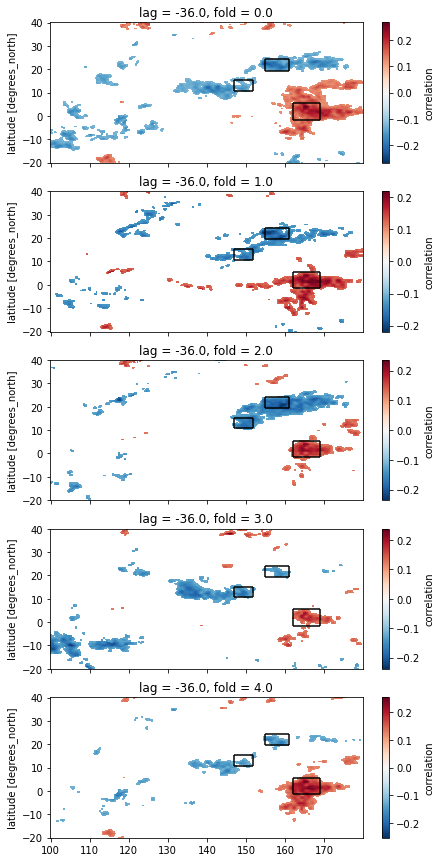

In [56]:
fig, axes = plt.subplots(nrows = 5, figsize = (7,15), sharex = True)
for i in corrpattern.coords['fold']:
    ax = axes[int(i)]
    field = corrpattern['correlation'].sel(fold = i, lag = -36)
    field.sel(latitude = slice(-20,40), longitude = slice(100,180)).plot(ax = ax)
    ax.set_xlabel('')
    for region in regions.index:
        coords = regions.loc[region,:]
        ax.hlines(y = coords['latrange'].start, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop)
        ax.hlines(y = coords['latrange'].stop, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop)
        ax.vlines(x = coords['lonrange'].start, ymin = coords['latrange'].start, ymax = coords['latrange'].stop)
        ax.vlines(x = coords['lonrange'].stop, ymin = coords['latrange'].start, ymax = coords['latrange'].stop)

### Time aggregation, Detrending, de-seasonalizing Functions

In [4]:
def agg_time(array: xr.DataArray, ndayagg: int = 1, method: str = 'mean') -> xr.DataArray:
    """
    Aggegates a daily time dimension by rolling averaging,
    Time axis should be continuous, otherwise non-neighbouring values are taken together. 
    It returns a left stamped aggregation of ndays
    Trailing Nan's are removed.
    """
    assert (np.diff(array.time) == np.timedelta64(1,'D')).all(), "time axis should be a continuous daily to be aggregated, though nan is allowed"

    name = array.name
    attrs = array.attrs
    f = getattr(array.rolling({'time':ndayagg}, center = False), method) # Stamped right
    array = f()
    array = array.assign_coords(time = array.time - pd.Timedelta(str(ndayagg - 1) + 'D')).isel(time = slice(ndayagg - 1, None)) # Left stamping, trailing nans removed
    array.name = name
    array.attrs = attrs
    return array

def fit_poly(array, degree: int = 3, year: int = None) -> xr.DataArray:
    """
    Fit 3rd order seasonal polynomial for each gridpoint in this data. 
    X is day of the year.
    Possibly for a single year, otherwise all years are joined
    If fitted per year discontinuities around winter are more likely.
    returns array of coefficients.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = array.stack({'latlon':['latitude','longitude']})
    coefs = np.polynomial.polynomial.polyfit(x = X, y = y, deg = degree)
    coefs = xr.DataArray(coefs, dims = ('coefs','latlon'), coords = y.coords['latlon'].coords)
    coefs = coefs.assign_coords({'coefs':np.arange(degree+1)})
    return coefs.unstack('latlon')

def evaluate_poly(array : xr.DataArray, coefs: xr.DataArray, year: int = None):
    """
    Evaluates the polynomial on the first time dimension. np.Polyval cannot do this for all gridcells at once
    So custom computation.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = xr.DataArray(np.zeros(array.shape), coords = array.coords, dims = array.dims)
    for degree in range(len(coefs)): # possibly later: https://en.wikipedia.org/wiki/Horner%27s_method
        y += X**degree * coefs.sel(coefs = degree, drop = True)
    return y

def deseasonalize(array: xr.DataArray, per_year: bool = False, return_polyval: bool = False, degree = 3):
    """
    If per year then trend is removed (and likely also interannual variability)
    plus you'll get a jump on the first of january. (not so important for summer)
    """
    deseasonalized = array.copy()
    deseasonalized.name = f'{deseasonalized.name}-anom'
    if per_year:
        years = np.unique(array.time.dt.year)
        if return_polyval:
            polyval = array.copy()
        for year in years:
            yearly_polyval = evaluate_poly(array, coefs = fit_poly(array, year = year, degree = degree), year = year)
            deseasonalized.loc[deseasonalized.time.dt.year == year,...] = deseasonalized.loc[deseasonalized.time.dt.year == year,...] - yearly_polyval
            if return_polyval:
                polyval.loc[polyval.time.dt.year == year,...] = yearly_polyval
    else:
        polyval = evaluate_poly(array, coefs = fit_poly(array, degree = degree))
        deseasonalized -= polyval
    if return_polyval:
        return deseasonalized, polyval
    else:
        return deseasonalized


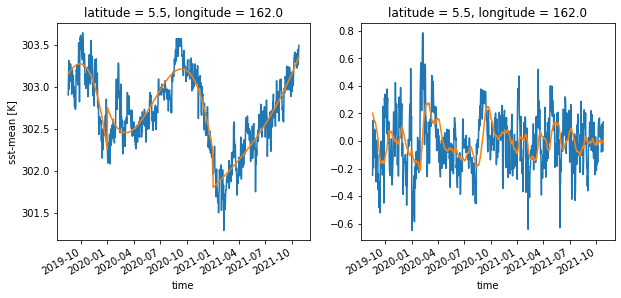

In [41]:
start = -800
latidx = -1
lonidx = 0
detrended, polyval = deseasonalize(warm,per_year=True, return_polyval=True)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}).mean()[start:].plot(ax = axes[1])

Per year removes interannual variability (rolling 3000 would result in nonesense). Trend is also removed. Intra-annual peaks are however still present, same timing as per_year=False

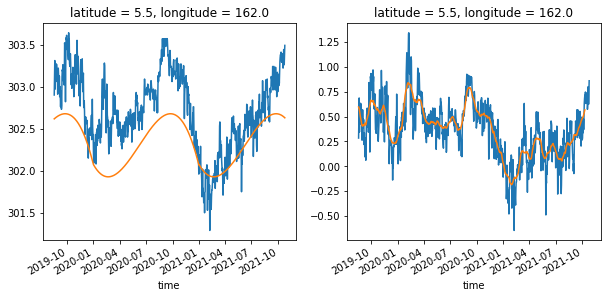

In [48]:
detrended, polyval = deseasonalize(warm,per_year=False, return_polyval=True, degree = 3)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}, center = True).mean()[start:].plot(ax = axes[1])

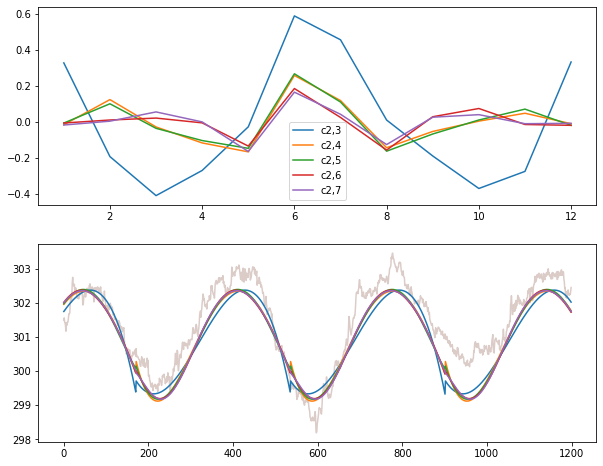

In [162]:
# Region cold2 seems to have most seasonal cycle.
fig, axes = plt.subplots(nrows = 2, figsize = (10,8))
for degree in [3,4,5,6,7]:
    #for key,field in components.items():
    key = 'c2'
    field = cold2
    ds, polyval = deseasonalize(field, per_year=False, return_polyval=True, degree = degree)
    spat = spatial_mean(ds)
    cycle = spat.groupby(spat.time.dt.month).mean()
    axes[0].plot(cycle.month, cycle.values, label = f'{key},{degree}')
    axes[1].plot(polyval[-1200:,0,-1])
axes[1].plot(field[-1200:,0,-1], zorder = 0, alpha = 0.3)
axes[0].legend()

Not a lot of difference beyond 4th order fitting. (response needs 5th order. see below)

### Versions of the sst index, and properties
The mean(cold1,cold2) version proved most similar to the original predictor.

In [295]:
# Aggregation of time.
def makeindex(deseason = True, remove_interannual = True, timeagg: int = None):
    """ 
    Whether to deseason on the daily timescale and per gridpoint
    Remove interannual only relevant if deasonalizing
    Aggregation by time possible before constructing the index (left stamping)
    """
    components = {'w':warm.copy(),'c1':cold1.copy(),'c2':cold2.copy()}
    if deseason:
        for key,field in components.items():
            components[key] = deseasonalize(field,per_year=remove_interannual, return_polyval=False, degree = 4)
    if not (timeagg is None):
        for key,field in components.items():
            components[key] = agg_time(array = field, ndayagg = timeagg)
    #index = spatial_mean(components['w']) - np.stack([spatial_mean(components['c1']),spatial_mean(components['c2'])]).min(axis = 0)
    index = spatial_mean(components['w']) - np.stack([spatial_mean(components['c1']),spatial_mean(components['c2'])]).mean(axis = 0)
    return index

In [296]:
index = makeindex(deseason=False, remove_interannual=False)
index2 = makeindex(deseason = True, remove_interannual=False)
index3 = makeindex(deseason = True, remove_interannual=False, timeagg = 21)
index4 = makeindex(deseason = True, remove_interannual=True)
indices = {'1d_seas_inter':index, 
           '1d_deseas_inter':index2, 
           '21d_deseas_inter':index3, 
           '1d_deseas_deinter':index4, 
          }

Annual means not always meaningful. Big seasonal differences in the index. This need not result from remaining seasonality in the patches themselves.

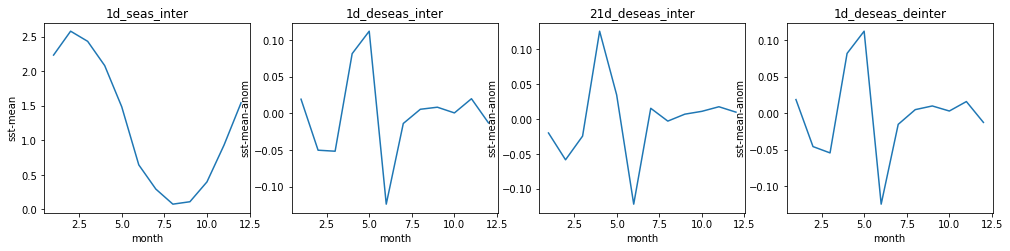

In [297]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (17,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    idx.groupby(idx.time.dt.month).mean().plot(ax = ax)
    ax.set_title(key)

Trends are not very present even though the patches themselves still have mean warming (if not deseasonalized per year).

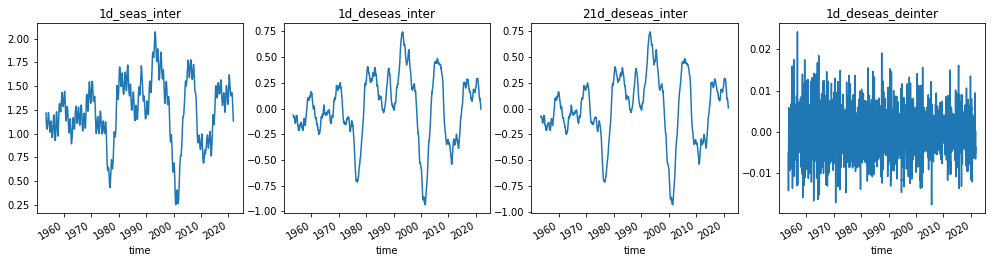

In [298]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (17,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    idx.rolling({'time':1200}).mean().plot(ax = ax)
    ax.set_title(key)

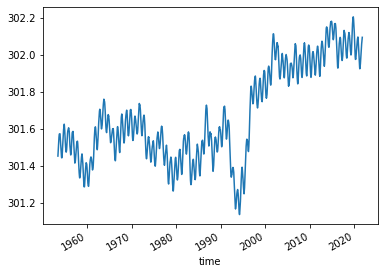

In [85]:
# here the warming trend in one of the patches. You also see seasonality in the patches of the equator (cold1 and cold2).
spatial_mean(cold1).rolling({'time':1200}).mean().plot()

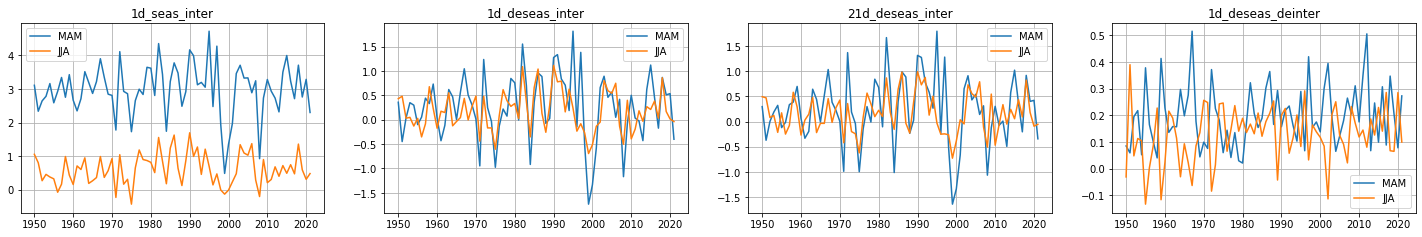

In [114]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (25,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    for season in ['MAM','JJA']:
        s = idx[idx.time.dt.season == season]
        s_yearly = s.groupby(s.time.dt.year).mean()
        ax.plot(s_yearly.year, s_yearly.values, label = season)
    ax.set_title(key)
    ax.legend()
    ax.grid(True)

Remarkable that in the latter case an anti-correlation seens to have formed. Other variables have anti-correlation only in the beginning of the timeseries. 
Also 21-day version (before index construction) is not dissimilar from the 1day version, in this seasonally aggregated vision.

#### Correspondence to covariance timeseries.

In [299]:
sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.models import map_foldindex_to_groupedorder

filepath = '/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
df = pd.read_parquet(filepath)
df = df.sort_index(axis =1)
# We must read fold 4, because this is the only one not using a large part of our data for training.
#order = map_foldindex_to_groupedorder(df, n_folds = 5) # strictly speaking fold 4 will remain fold 4

In [300]:
# These are pre-lagged
timeagg = 21
lag = -15
ssts = df.loc[:,(4,'sst_nhplus',timeagg,slice(None),lag,4,'spatcov')]

In [301]:
ssts_unlagged = ssts.copy().dropna()
ssts_unlagged.index = ssts_unlagged.index - pd.Timedelta(timeagg + abs(lag), unit ='D')

In [302]:
correlations = pd.DataFrame(np.nan, index = indices.keys(), columns = ['pearson','spearman'])
for key,idx in indices.items():
    subset = idx.to_pandas().loc[ssts_unlagged.index]
    correlations.loc[key,'pearson'] = pearsonr(subset.values,ssts_unlagged.values.squeeze())[0]
    correlations.loc[key,'spearman'] = spearmanr(subset.values,ssts_unlagged.values.squeeze())[0]

In [165]:
correlations

,pearson,spearman
1d_seas_inter,0.504876,0.503117
1d_deseas_inter,0.867091,0.850240
21d_deseas_inter,0.932223,0.925201
1d_deseas_deinter,0.150877,0.140422


In [303]:
correlations

,pearson,spearman
1d_seas_inter,0.603546,0.594801
1d_deseas_inter,0.897683,0.879629
21d_deseas_inter,0.962036,0.952390
1d_deseas_deinter,0.148591,0.143815


This is good news. Apparently versions of the index corresponds well to the spatial covariance (in the 1981-2019 period at least). Interannual variability should not be removed. That much is clear.

4th order de-seasonalizing results in higher maximum correlations (0.93, instead of 0.9). That all is for the min(cold1, cold2). The index based on mean of the two seems to correspond even more (0.96 with 4th order fitting)

#### Correspondence to ENSO index
Enso in summer is less well defined.
Do I need to de-seasonalize enso or is only the variability related to the month? Not really.

In [558]:
nino = pd.read_hdf('/scistor/ivm/jsn295/paper4/nino_daily.h5')

In [562]:
nino4 = nino.loc[(slice(None),0),('nino',1,4,'mean')] # unlagged version.
nino4.index = nino4.index.droplevel(-1)

In [568]:
correlations = pd.DataFrame(np.nan, index = indices.keys(), columns = ['pearson','spearman'])
for key,idx in indices.items():
    subset = idx.to_pandas().loc[nino4.index]
    correlations.loc[key,'pearson'] = pearsonr(subset.values,nino4.values.squeeze())[0]
    correlations.loc[key,'spearman'] = spearmanr(subset.values,nino4.values.squeeze())[0]

In [569]:
correlations

,pearson,spearman
1d_seas_inter,0.332169,0.330119
1d_deseas_inter,0.624514,0.583651
21d_deseas_inter,0.638562,0.591300
1d_deseas_deinter,0.057045,0.056151


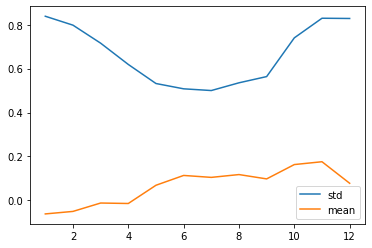

In [570]:
fig, ax = plt.subplots()
for m in ['std','mean']:
    gr = nino4.groupby(nino4.index.month)
    f = getattr(gr, m)
    val = f()
    ax.plot(val.index, val.values, label = m)
ax.legend()

## Creation of temperature target

In [64]:
subdomainlats = slice(40,56)
subdomainlons = slice(-5,24)
t2m = xr.open_dataarray(eradir / 't2m_europe.nc').sel(latitude = subdomainlats, longitude = subdomainlons)
clusterfield = xr.open_dataarray('/scistor/ivm/jsn295/clusters/t2m-q095.nc').sel(nclusters = 15, latitude = subdomainlats, longitude = subdomainlons)

In [65]:
t2manom, polyval = deseasonalize(t2m,per_year=False, return_polyval=True, degree = 3)

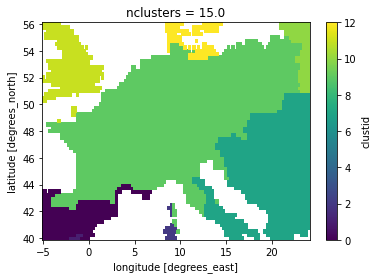

In [70]:
clusterfield.plot()

In [77]:
t2manom2, polyval2 = deseasonalize(t2m,per_year=False, return_polyval=True, degree = 4)

In [86]:
t2manom3, polyval3 = deseasonalize(t2m,per_year=False, return_polyval=True, degree = 5)

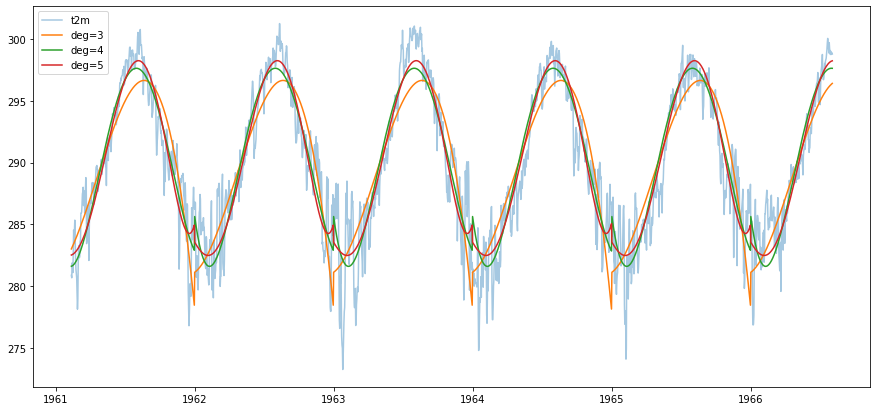

In [91]:
timeslice = slice(4000,6000) # indices
#timeslice = slice(14000,20000) # indices
fig, ax = plt.subplots( figsize = (15,7))
ax.plot(t2m[timeslice,0,-1].time, t2m[timeslice,0,-1].values, label = 't2m', alpha = 0.4)
ax.plot(t2m[timeslice,0,-1].time, polyval[timeslice,0,-1].values, label = 'deg=3')
ax.plot(t2m[timeslice,0,-1].time, polyval2[timeslice,0,-1].values, label = 'deg=4')
ax.plot(t2m[timeslice,0,-1].time, polyval3[timeslice,0,-1].values, label = 'deg=5')
ax.legend()

Not a very good fit with 3rd order polynomial. Temperatures are more peaked in summer. You can see that seasonal dependence keeps existing by looking at average residuals per month.

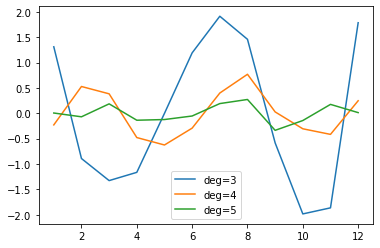

In [93]:
fig, ax = plt.subplots()
for data, degree in zip([t2manom,t2manom2,t2manom3], [3,4,5]):
    m = spatial_mean(data)
    s = m.groupby(m.time.dt.month).mean()
    ax.plot(s.month, s.values, label = f'deg={degree}')
ax.legend()

In [146]:
respagg = 31
reduced = t2manom3.groupby(clusterfield).mean('stacked_latitude_longitude')
reduced = reduced.sel(clustid = 9)
reduced = agg_time(reduced, ndayagg = respagg)

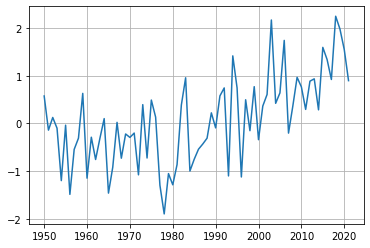

In [147]:
fig, ax = plt.subplots()
summer = reduced.loc[reduced.time.dt.season == 'JJA']
summermean = summer.groupby(summer.time.dt.year).mean()
ax.plot(summermean.year, summermean.values)
ax.grid(True)

Trend visible for the summer temperature anomalies (31day aggregation, left stamped.) Also heatwaves 2003, 2006, 2015, 2018, 2019, 2020.
#### Correspondence of this deaseasonalized version with original target
Original target only deseasonalized with climate of 1979-2019. For full period 1950-2019 the anomalies will thus have different means.

In [148]:
resp = pd.read_parquet('/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet').loc[:,(slice(None),respagg,9)]
resp_old = pd.read_parquet('/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.pre1981.parquet').loc[:,(slice(None),respagg,9)]

In [149]:
resp_joined = pd.concat([resp_old,resp]).iloc[:,0]
print(f'original mean {float(resp_joined.mean())}, new mean {float(reduced.mean())}')

original mean -0.33872510559770613, new mean -3.998967804363929e-05


In [150]:
print('pearson', pearsonr(resp_joined,reduced.loc[resp_joined.index]))
print('spearman', spearmanr(resp_joined,reduced.loc[resp_joined.index]))

pearson (0.9684017686452451, 0.0)
spearman SpearmanrResult(correlation=0.9643886340625786, pvalue=0.0)


Really high correspondence, which is very good. Similar timescale is of real importance (daily new, monthly original gives only 0.3 correlation).

### Running correlations between indices and new target.
Lagging by 15+21 days (for the left stamped 21day version at least). Period of stronger correlation is time dependend. For instance after 2000 you seem to get something comparable to the usable predictor in the earlier studies. Interestingly there seems to be periods of reversal.

In [382]:
timeagg = 21 # That is precursor timeagg
separation = -15

In [383]:
def lag_precursor(precursor: pd.Series, separation: int, timeagg: int):
    """timeagg = timeagg of the precursor"""
    lagged = precursor.copy()
    lagged.index = lagged.index + pd.Timedelta(abs(separation) + timeagg, unit = 'D')
    return lagged

def combine_index_response(idx, idxname, lag = True, separation = -15, only_months: list = None, detrend_response = False):
    """
    If summeronly then only summer values are used for detrending.
    """
    if idxname.startswith('21'):
        precursoragg = 21
    else:
        precursoragg = 1
    if lag:
        lagged = lag_precursor(idx.to_pandas(), separation = separation, timeagg = precursoragg)
        lagged.name = idx.name
    response = reduced.to_pandas()
    response.name = reduced.name
    combined = pd.merge(lagged, response, left_index = True, right_index = True, how = 'inner')
    if not (only_months is None):
        combined = combined.loc[combined.index.month.map(lambda m: m in only_months),:]
    if detrend_response:
        combined.loc[:,response.name] = detrend(combined.loc[:,response.name])
    return combined


In [384]:
for key,idx in indices.items():
    combined = combine_index_response(idx = idx, idxname = key, lag = True, separation=15, only_months = [6,7,8], detrend_response = True)
    combined = combined.loc[slice('2000-01-01','2020-01-01'),:]
    print(key)
    print('pearson', pearsonr(combined.iloc[:,0], combined.iloc[:,1]))
    print('spearman', spearmanr(combined.iloc[:,0], combined.iloc[:,1]))

1d_seas_inter
pearson (0.3974203, 1.1431237667969398e-70)
spearman SpearmanrResult(correlation=0.39844754474969735, pvalue=4.669660799977448e-71)
1d_deseas_inter
pearson (0.3929471, 5.434953077394255e-69)
spearman SpearmanrResult(correlation=0.3922530515664834, pvalue=9.842390591068242e-69)
21d_deseas_inter
pearson (0.40396503, 3.608484847933003e-73)
spearman SpearmanrResult(correlation=0.4030599112915308, pvalue=8.063583076720173e-73)
1d_deseas_deinter
pearson (0.1033484, 8.911053689282802e-06)
spearman SpearmanrResult(correlation=0.11443090855273096, pvalue=8.593747472550396e-07)


TODO: how does correlation behave with leadtime? When detrended seems to drop with increasing lag. But decreasing lag not neccesarily.

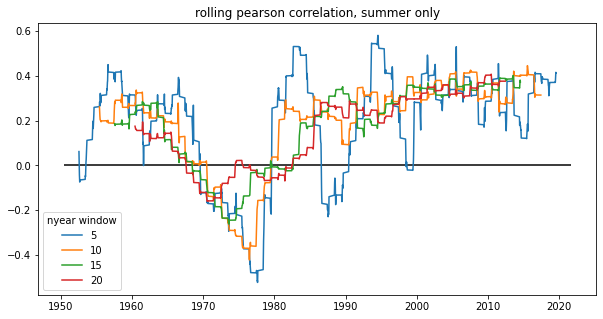

In [385]:
idxname = '21d_deseas_inter'
combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, only_months = [6,7,8], detrend_response = True)

fig, ax = plt.subplots(figsize = (10,5))
for nyears in [5,10,15,20]:
    test = combined.rolling(92*nyears, center = True).corr()
    test = test.loc[(slice(None),'t2m-mean-anom'),'sst-mean-anom']
    test.index = test.index.droplevel(-1)
    ax.plot(test.index, test.values, label = str(nyears))
ax.hlines(y = 0, xmin = combined.index.min(), xmax = combined.index.max())
ax.legend(title = 'nyear window')
ax.set_title('rolling pearson correlation, summer only')
plt.show()

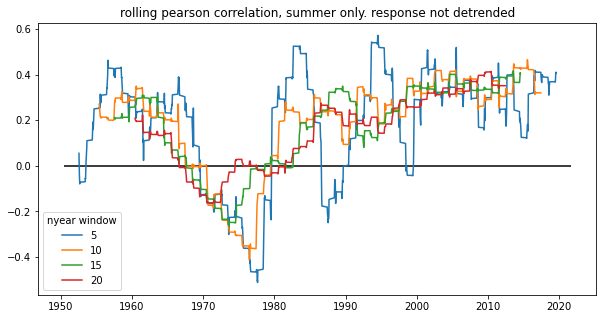

In [386]:
idxname = '21d_deseas_inter'
combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, only_months = [6,7,8], detrend_response = False)

fig, ax = plt.subplots(figsize = (10,5))
for nyears in [5,10,15,20]:
    test = combined.rolling(92*nyears, center = True).corr()
    test = test.loc[(slice(None),'t2m-mean-anom'),'sst-mean-anom']
    test.index = test.index.droplevel(-1)
    ax.plot(test.index, test.values, label = str(nyears))
ax.hlines(y = 0, xmin = combined.index.min(), xmax = combined.index.max())
ax.legend(title = 'nyear window')
ax.set_title('rolling pearson correlation, summer only. response not detrended')
plt.show()

Higher correlations occur after the year 2000

#### Behaviour in spring and with leadtime
June july correlation is highest. Spring correlation not neccesarily stronger.

In [454]:
# spring into summer
idxname = '21d_deseas_inter'

monthlists = [[month, month+1] for month in range(2,12)]
timeslices = [slice('1950-01-01','1970-01-01'),slice('1970-01-01','1980-01-01'),slice('1980-01-01','2000-01-01'),slice('2000-01-01','2021-01-01')]

correlations = []

for sl in timeslices:
    correlation = pd.DataFrame(np.nan, index = pd.MultiIndex.from_tuples(monthlists, names = ['month1','month2']), columns = ['pearson','spearman'])
    for monthlist in monthlists:
        combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, only_months = monthlist, detrend_response = False)
        comb = combined.loc[sl,:]
        correlation.loc[tuple(monthlist),'pearson'] = pearsonr(comb.iloc[:,0], comb.iloc[:,1])[0]
        correlation.loc[tuple(monthlist),'spearman'] = spearmanr(comb.iloc[:,0], comb.iloc[:,1])[0]
    correlations.append(correlation)

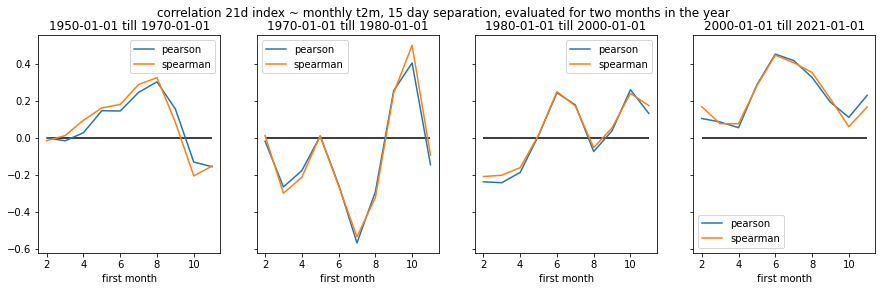

In [463]:
fig,axes = plt.subplots(ncols = len(timeslices), sharey=True, figsize = (15,4))
for i, sl in enumerate(timeslices):
    correlation = correlations[i]
    ax = axes[i]
    for cor in correlation.columns:
        ax.plot(correlation.index.get_level_values(0), correlation[cor], label = cor)
    ax.legend()
    ax.set_title(f'{sl.start} till {sl.stop}')
    ax.set_xlabel('first month')
    ax.hlines(0,2,11)
fig.suptitle('correlation 21d index ~ monthly t2m, 15 day separation, evaluated for two months in the year')
plt.show()

Spring connection certainly not the strongest. JJ seems to be the best. 1970-1980 period has this peculiar change from negative to positive.

In [475]:
# With leadtime, JJA
idxname = '1d_deseas_inter'
separations = list(range(0,405,5)) # in days
timeslices = [slice('1950-01-01','1970-01-01'),slice('1970-01-01','1980-01-01'),slice('1980-01-01','2000-01-01'),slice('2000-01-01','2021-01-01')]

correlations = []

for sl in timeslices:
    correlation = pd.DataFrame(np.nan, index = pd.Index(separations, name = 'sep'), columns = ['pearson','spearman'])
    for sep in separations:
        combined = combine_index_response(idx = indices[idxname], idxname = idxname, lag = True, 
                                          separation = sep, only_months = [6,7], detrend_response = True)
        comb = combined.loc[sl,:]
        correlation.loc[sep,'pearson'] = pearsonr(comb.iloc[:,0], comb.iloc[:,1])[0]
        correlation.loc[sep,'spearman'] = spearmanr(comb.iloc[:,0], comb.iloc[:,1])[0]
    correlations.append(correlation)

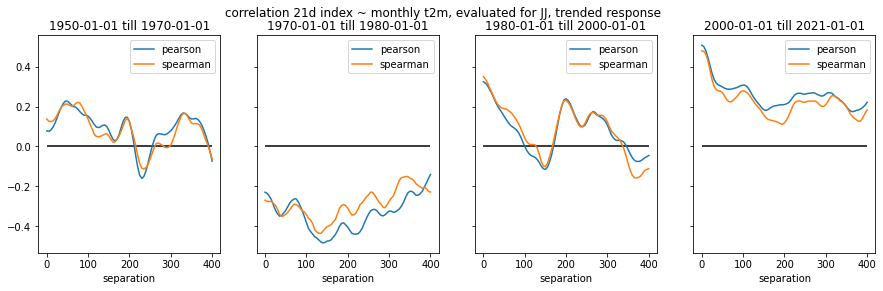

In [474]:
fig,axes = plt.subplots(ncols = len(timeslices), sharey=True, figsize = (15,4))
for i, sl in enumerate(timeslices):
    correlation = correlations[i]
    ax = axes[i]
    for cor in correlation.columns:
        ax.plot(correlation.index, correlation[cor], label = cor)
    ax.legend()
    ax.set_title(f'{sl.start} till {sl.stop}')
    ax.set_xlabel('separation')
    ax.hlines(0,min(separations),max(separations))
fig.suptitle('correlation 21d index ~ monthly t2m, evaluated for JJ, trended response')
plt.show()

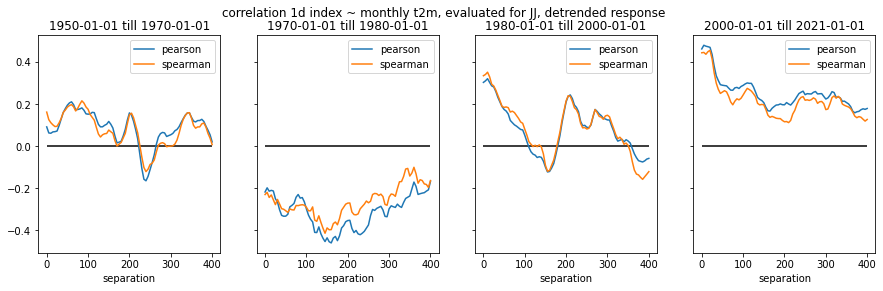

In [477]:
fig,axes = plt.subplots(ncols = len(timeslices), sharey=True, figsize = (15,4))
for i, sl in enumerate(timeslices):
    correlation = correlations[i]
    ax = axes[i]
    for cor in correlation.columns:
        ax.plot(correlation.index, correlation[cor], label = cor)
    ax.legend()
    ax.set_title(f'{sl.start} till {sl.stop}')
    ax.set_xlabel('separation')
    ax.hlines(0,min(separations),max(separations))
fig.suptitle('correlation 1d index ~ monthly t2m, evaluated for JJ, detrended response')
plt.show()

I find the 1970-1980 region a bit suspicious, as it does not close in to zero quickly, actually the negative correlation seems to increase with leadtime. Perhaps the period is really persistent.
Detrending does not really make a difference for this behavior.

### Matrix evaluation
Should this be combined with rolling time or different timeslices? Possibilities for the matrix:
* tercile categories (would show neg-neg anomalies in a different square as pos-pos)\
* median exceedence.
* or expected versus unexpected (neutral-neutral, neg-neg, pos-pos all expected) (unexpected would be periods of index reversal). (This is basically a derivative of the tercile matrix)

In [555]:
def digitize(combined_frame : pd.DataFrame, thresholds: pd.DataFrame):
    """
    shapes: frame (n_samples, n_variables), thresholds (nthresholds, n variables)
    """
    which_category = combined_frame.copy()
    for var in combined_frame.columns:
        which_category[var] = np.digitize(combined_frame[var], thresholds[var])
    return which_category

def count_combinations(digitized_array, normalize: bool = False):
    """
    Digitized array has e.g. 0,1,2 values for three terciles.
    returns count matrix. If normalized then frequencies (count/total)
    """
    nclasses = np.unique(digitized_array).max() + 1
    counts = pd.DataFrame(np.zeros((nclasses,nclasses)), 
                          index = pd.RangeIndex(nclasses, name = digitized_array.columns[0]), 
                          columns = pd.RangeIndex(nclasses, name = digitized_array.columns[1]))
    for i in range(len(digitized_array)):
        a,b = digitized_array.iloc[i,:]
        counts.iloc[a,b] += 1
    if normalize:
        counts = counts/counts.sum().sum()
    return counts

def visualize(tab: pd.DataFrame):
    fig, ax = plt.subplots(figsize = (4,3.5))
    im = ax.imshow(tab.values, vmin = 0, vmax = 1 / tab.shape[0], cmap = 'viridis', aspect = 'auto')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(tab.columns)))
    ax.set_xticklabels(tab.columns.to_flat_index().values, size = 12)
    ax.set_yticks(np.arange(len(tab.index)))
    ax.set_yticklabels(tab.index.to_flat_index().values, size = 12)
    ax.set_ylabel(tab.index.name)
    ax.set_xlabel(tab.columns.name)

    for i in tab.index:
        for j in tab.columns:
            ax.text(j,i,str(np.round(tab.loc[i,j],3)), horizontalalignment='center',verticalalignment='center',size = 14, color = 'white')
    return fig, ax

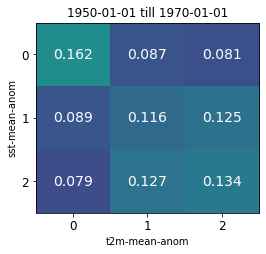

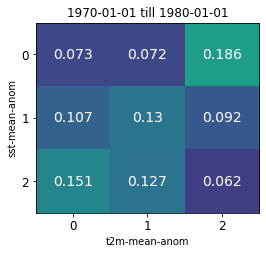

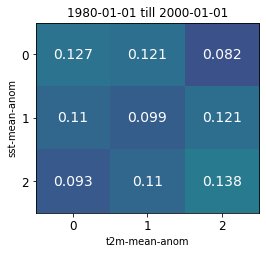

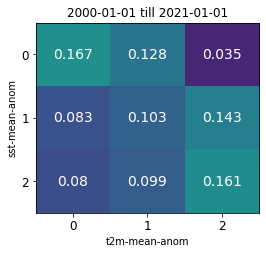

In [556]:
idxname = '21d_deseas_inter'

for sl in timeslices:
    combined = combine_index_response(idx = indices[idxname], idxname = idxname, 
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)
    comb = combined.loc[sl,:]
    thresholds = comb.quantile([0.33,0.66])
    #thresholds = comb.quantile([0.5])
    counts = count_combinations(digitized_array=digitize(comb, thresholds=thresholds), normalize = True)
    fig, ax = visualize(counts)
    ax.set_title(f'{sl.start} till {sl.stop}')
    plt.show()

least clear link in 1980-2000. Symmetry for median confusion matrix happens because all axes are required to sum up to 0.5 in case of these median exceedences.

### Involvement of ENSO
two-way subsetting.